In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import statsmodels.api as sm
from numpy.linalg import inv

In [41]:
%reload_ext autoreload
%autoreload 2

import my_tools as tools

In [4]:
eps = 0.01
alpha = 0.1
steps = 1000

# Methods

In [6]:
def var(y_orig, y_pred):
    cost = 0
    cost += ((y_orig - y_pred) ** 2)
    cost = cost.sum()
    return cost

In [7]:
def mse(y_orig, y_pred):
    return var(y_orig, y_pred) / y_orig.shape[0]

In [8]:
def R_sq(y_orig, y_pred):
    n = len(y_orig)
    return (y_orig.var()*(n-1) - var(y_orig, y_pred)) / (y_orig.var()*(n-1))

In [9]:
def RSE(y, y_pred, df):
    n = len(y)
    n = len(y)
    return math.sqrt(var(y, y_pred)/(n - df))

In [44]:
def gradient_descent(X, y, w, b, alpha):
    n = len(X)
    y_pred = w * X + b
    error = y_pred - y
    
    w_d = (1/n) * np.dot(X, error)
    b_d = (1/n) * np.sum(error)
    
    new_w = w - alpha * w_d
    new_b = b - alpha * b_d

    
    return new_w, new_b

In [41]:
def my_fit(X, y):
    w, b = (0, 0)
    std = X.std()
    mean = X.mean()
    X_scaled = (X - mean)/std

    
    w_history = []
    b_history = []
    
    for step in range(steps):
        w_new, b_new = gradient_descent(X_scaled, y, w, b, alpha)
        w_history.append(w_new)
        b_history.append(b_new)
        if abs(w_new - w) < eps and abs(b_new - b) < eps:
            break
        w, b = (w_new, b_new)

    w_orig = w/std
    b_orig = b - (w * mean)/std
    
    return (w_orig, b_orig, w_history, b_history)

In [42]:
def SE_b(X, y, y_pred, df):
    n = len(X)
    res_var = var(y, y_pred) / (n - df)
    print(math.sqrt(res_var))
    squared_error = X.var() * (n-1)
    mean = X.mean()
    
    
    return math.sqrt(res_var * (1/n + (mean**2)/squared_error))

def SE_w(X, y, y_pred, df):
    n = len(X)
    res_var = var(y, y_pred) / (n - df)
    squared_error = X.var() * (n-1)

    return math.sqrt(res_var / squared_error)

# Simple Linear Regression

In [14]:
df = pd.read_csv('advertising.csv')

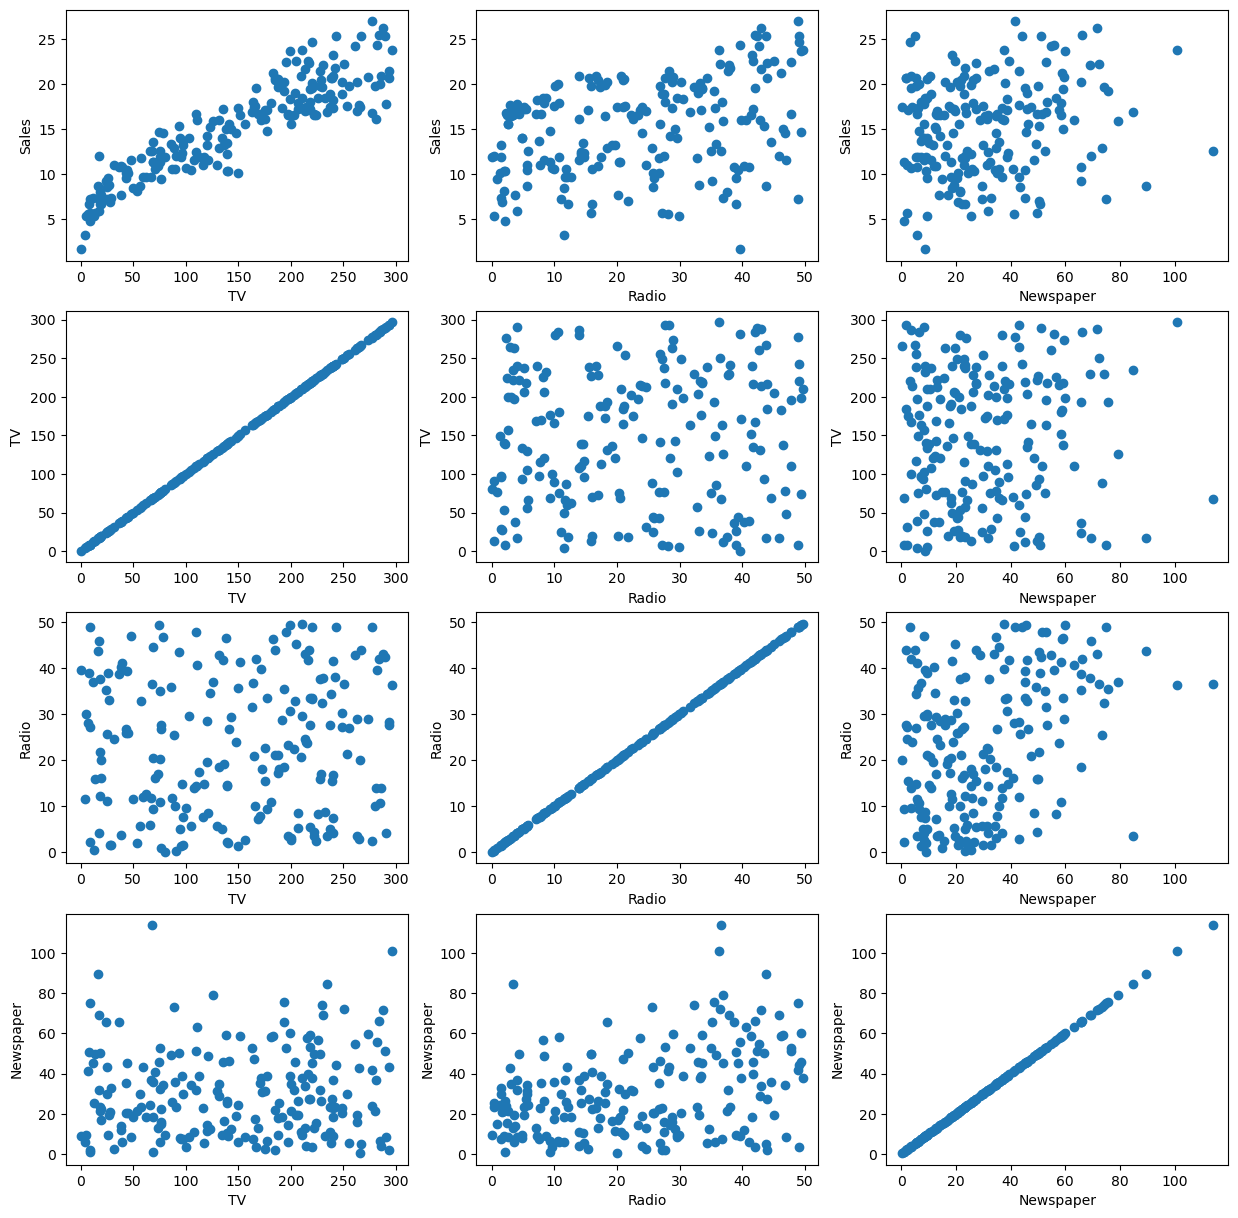

In [16]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

rows = ['Sales', 'TV', 'Radio', 'Newspaper']
columns = ['TV', 'Radio', 'Newspaper']


for i in range(len(rows)):
    for j in range(len(columns)):
        axs[i, j].set(xlabel=columns[j], ylabel=rows[i])
        axs[i, j].scatter(x=df[columns[j]], y =df[rows[i]])

In [48]:
X = df['TV']
y = df['Sales']

w, b, w_hist, b_hist = my_fit(X, y)
y_pred = w * X + b
print(w, b)

0.055102330868625767 6.9318449011829895


In [14]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     856.2
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           7.93e-74
Time:                        15:17:17   Log-Likelihood:                -448.99
No. Observations:                 200   AIC:                             902.0
Df Residuals:                     198   BIC:                             908.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9748      0.323     21.624      0.0

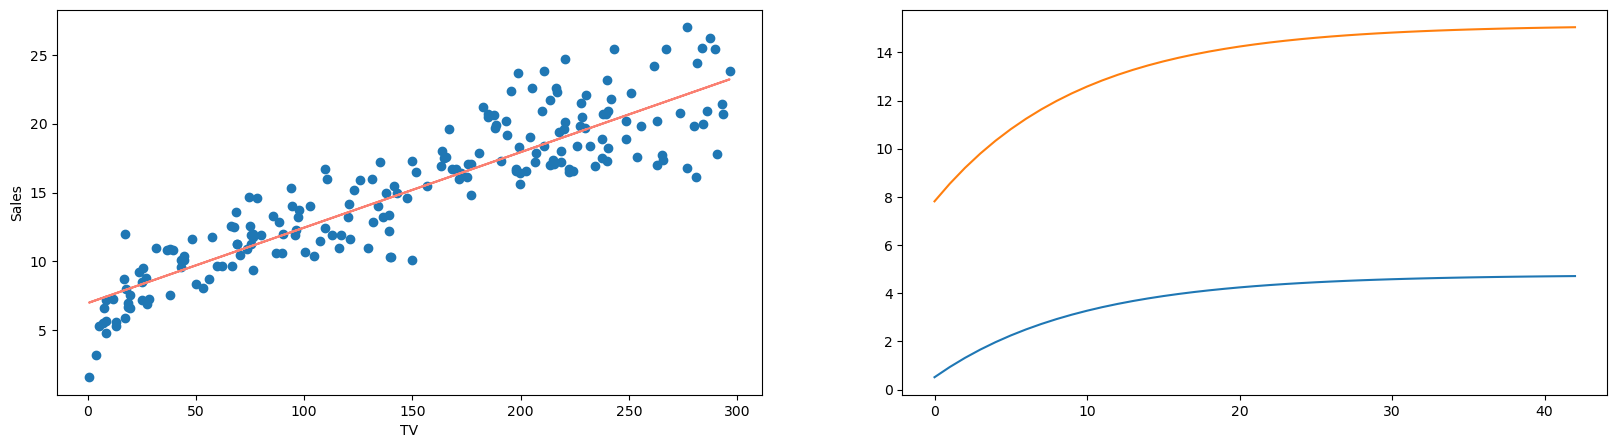

In [82]:
fig, axs = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
axs[0].set(xlabel='TV', ylabel='Sales')
axs[0].scatter(x=df['TV'], y=df['Sales'])
axs[0].plot(X, y_pred, color='salmon')



axs[1].plot(w_hist)
axs[1].plot(b_hist)


In [83]:
acc_df = pd.DataFrame(index=['w', 'b'], columns=['Coef', 'Std. error', 't-statistic', 'p-value'])

In [86]:
acc_df.loc['w', 'Coef'] = w
acc_df.loc['w', 'Std. error'] = SE_w(X, y, y_pred, 2)
acc_df.loc['w', 't-statistic'] = w/acc_df.loc['w', 'Std. error']
acc_df.loc['w', 'p-value'] = t.sf(acc_df.loc['w', 't-statistic'], len(X) - 2)

acc_df.loc['b', 'Coef'] = b
acc_df.loc['b', 'Std. error'] = SE_b(X, y, y_pred, 2)
acc_df.loc['b', 't-statistic'] = b/acc_df.loc['b', 'Std. error']
acc_df.loc['b', 'p-value'] = t.sf(acc_df.loc['b', 't-statistic'], len(X) - 2)

2.2985615446693606


In [88]:
acc_df

,Coef,Std. error,t-statistic,p-value
w,0.054791,0.001898,28.86951,0.0
b,6.976588,0.322949,21.602747,0.0


### Scikit-Learn

In [89]:
X_orig = df['TV'].values
X = [[i] for i in df['TV'].values]
y = df['Sales']

In [90]:
reg = LinearRegression().fit(X, y)

In [91]:
w = reg.coef_
b = reg.intercept_
y_pred = w * X_orig + b 
print(w[0], b)

0.05546477046955886 6.9748214882298925


In [96]:
acc_df = pd.DataFrame(index=['w', 'b'], columns=['Coef', 'Std. error', 't-statistic', 'p-value'])
acc_df.loc['w', 'Coef'] = w
acc_df.loc['w', 'Std. error'] = SE_w(X_orig, y, y_pred, 2)
acc_df.loc['w', 't-statistic'] = acc_df.loc['w', 'Coef']/acc_df.loc['w', 'Std. error']
acc_df.loc['w', 'p-value'] = 2 * t.sf(np.abs(acc_df.loc['w', 't-statistic']), len(X) - 2)

acc_df.loc['b', 'Coef'] = b
acc_df.loc['b', 'Std. error'] = SE_b(X_orig, y, y_pred, 2)
acc_df.loc['b', 't-statistic'] = acc_df.loc['b','Coef']/acc_df.loc['b', 'Std. error']
acc_df.loc['b', 'p-value'] = 2 * t.sf(np.abs(acc_df.loc['b', 't-statistic']), len(X) - 2)

2.2957457136214456


In [135]:
quant_df = pd.DataFrame(columns=['Quantity', 'Value'])
quant_df['Quantity'] = ['RSE', 'R^2']
quant_df = quant_df.set_index('Quantity')


In [139]:
quant_df.loc['R^2', 'Value'] = R_sq(y, y_pred)
quant_df.loc['RSE', 'Value'] = RSE(y, y_pred, 2)

In [140]:
quant_df

,Value
Quantity,
RSE,2.295746
R^2,0.812176


In [130]:
from sklearn.metrics import r2_score
r2_score(y, y_pred)

0.8121757029987414

In [1]:
import seaborn as sns

<Axes: >

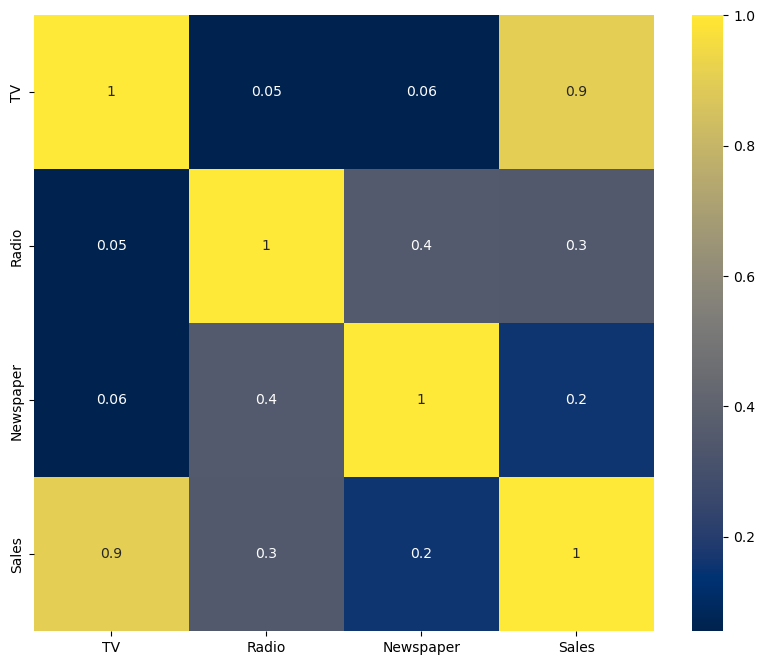

In [15]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='cividis', fmt=".1g")

# Removing Additive Assumption

In [1]:
%reload_ext autoreload
%autoreload 2

import my_tools as tools

In [5]:
df = pd.read_csv('advertising.csv')

In [19]:
X = df[['TV', 'Radio']]
y = df['Sales']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     856.2
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           7.93e-74
Time:                        17:53:15   Log-Likelihood:                -448.99
No. Observations:                 200   AIC:                             902.0
Df Residuals:                     198   BIC:                             908.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9748      0.323     21.624      0.0

In [13]:
X = df[['TV', 'Radio']]
X['interaction'] = df['TV'] * df['Radio']
X = X.values

y = df['Sales']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     694.7
Date:                Sat, 21 Feb 2026   Prob (F-statistic):          3.90e-104
Time:                        16:12:22   Log-Likelihood:                -370.83
No. Observations:                 200   AIC:                             749.7
Df Residuals:                     196   BIC:                             762.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1926      0.410     15.101      0.0

# Calculating Leverage Points

In [3]:
df = pd.read_csv('advertising.csv')

In [4]:
df.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales'], dtype='str')

In [37]:
X = df[['TV']].values
X2 = sm.add_constant(X)
Xt = X2.T
Xf = np.matmul(Xt, X2)

In [38]:
Xt = inv(Xf)
H = np.matmul(np.matmul(X2, Xt), X2.T)
H = np.diag(H)

In [39]:
y = df['Sales']
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     856.2
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           7.93e-74
Time:                        08:09:56   Log-Likelihood:                -448.99
No. Observations:                 200   AIC:                             902.0
Df Residuals:                     198   BIC:                             908.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9748      0.323     21.624      0.0

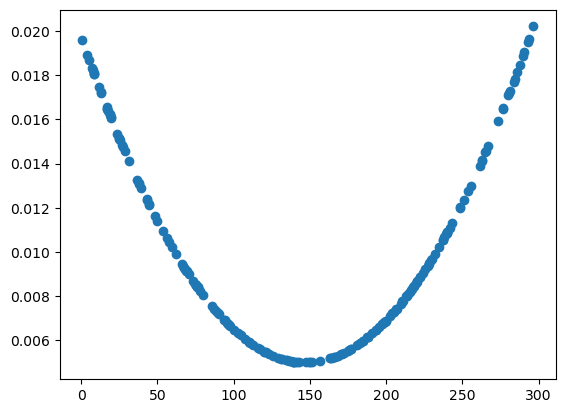

In [40]:
plt.scatter(x=df['TV'], y=H)

# Calculating Studentized Residual

In [80]:
X = df[['TV']].values
y = df['Sales']

In [83]:
W, int_, WH, IH = tools.my_fit(X, y)
y_pred = (np.multiply(W, X) + int_).flatten()
e = [ip - i for i, ip in zip(y, y_pred)]
RSE = tools.RSE(y, y_pred, 2)
SR = np.divide(e, RSE * np.sqrt(1 - H))

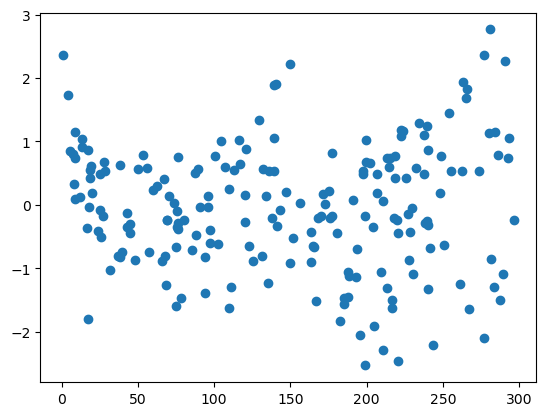

In [84]:
plt.scatter(x=X, y=SR)